# Scalr Case

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import numpy as np
import argparse
import time
import math
import random
import json
import pathlib
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image
import math

In [2]:
parser = argparse.ArgumentParser(description='PyTorch Graphical VINF')

parser.add_argument('-d', '--dataset', type=str, default='mnist', choices=['mnist'],
                    metavar='DATASET',
                    help='Dataset choice.')

parser.add_argument('-nc', '--no_cuda', action='store_true', default=False,
                    help='disables CUDA training')

parser.add_argument('--manual_seed', type=int, help='manual seed, if not given resorts to random seed.')

parser.add_argument('-li', '--log_interval', type=int, default=10, metavar='LOG_INTERVAL',
                    help='how many batches to wait before logging training status')

parser.add_argument('-od', '--out_dir', type=str, default='logs/', metavar='OUT_DIR',
                    help='output directory for model snapshots etc.')

fp = parser.add_mutually_exclusive_group(required=False)
fp.add_argument('-te', '--testing', action='store_true', dest='testing',
                help='evaluate on test set after training')
fp.add_argument('-va', '--validation', action='store_false', dest='testing',
                help='only evaluate on validation set')
parser.set_defaults(testing=True)

# optimization settings
parser.add_argument('-e', '--epochs', type=int, default= 30, metavar='EPOCHS',
                    help='number of epochs to train (default: 30)')
parser.add_argument('-es', '--early_stopping_epochs', type=int, default=15, metavar='EARLY_STOPPING',
                    help='number of early stopping epochs')

parser.add_argument('-bs', '--batch_size', type=int, default=2000, metavar='BATCH_SIZE',
                    help='input batch size for training (default: 100)')
parser.add_argument('-lr', '--learning_rate', type=float, default=0.00001, metavar='LEARNING_RATE',
                    help='learning rate')

parser.add_argument('-a', '--anneal', type=str, default="std", choices= ["std", "off", "kl"], help="beta annealing scheme")
parser.add_argument('--max_beta', type=float, default=1., metavar='MB',
                    help='max beta for warm-up')
parser.add_argument('--min_beta', type=float, default=0.0, metavar='MB',
                    help='min beta for warm-up')
parser.add_argument('-f', '--flow', type=str, default='planar', choices=['planar', 'NICE', 'NICE_MLP', 'real' ])
parser.add_argument('-nf', '--num_flows', type=int, default=5,
                    metavar='NUM_FLOWS', help='Number of flow layers, ignored in absence of flows')

parser.add_argument('--z_size', type=int, default=1, metavar='ZSIZE',
                    help='how many stochastic hidden units')


parser.add_argument('-vp', '--vampprior', type=bool, default=True, metavar='VAMPPRIOR',
                    help='choose whether to use VampPrior')

parser.add_argument('--num_pseudos', type=int, default=100, metavar='NUM_PSEUDOS',
                    help='number of pseudoinputs used for VampPrior')

parser.add_argument('--data_as_pseudo', type=bool, default=True, metavar='data_as_pseudo',
                    help='use random training data as pseudoinputs')

# gpu/cpu
parser.add_argument('--gpu_num', type=int, default=0, metavar='GPU', help='choose GPU to run on.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

if args.manual_seed is None:
    args.manual_seed = 42
random.seed(args.manual_seed)
torch.manual_seed(args.manual_seed)
np.random.seed(args.manual_seed)

if args.cuda:
    torch.cuda.set_device(args.gpu_num)
args.data_as_pseudo = False

args.batch_size = 200
args.num_flows = 5

### Generate the 'true' posterior and causal dependency

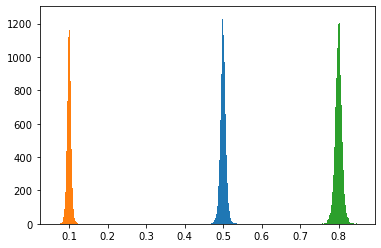

In [3]:
import matplotlib.pyplot as plt
total_num = 100000
loc_LS, scale_LS = 0.5, 0.004
pLS = np.random.logistic(loc_LS, scale_LS, total_num)

loc_LF, scale_LF = 0.1, 0.003
pLF = np.random.logistic(loc_LF, scale_LF, total_num)

loc_BD, scale_BD = 0.8, 0.005
pBD = np.random.logistic(loc_BD, scale_BD, total_num)

count_LS, bins_LS, ignored_LS = plt.hist(pLS, bins=500)
count_LF, bins_LF, ignored_LF = plt.hist(pLF, bins=500)
count_BD, bins_BD, ignored_BD = plt.hist(pBD, bins=500)

PLS = torch.from_numpy(pLS).float()

PLF = torch.from_numpy(pLF).float()

PBD = torch.from_numpy(pBD).float()



In [4]:
PBD.max(),PLF.max(),PLS.max()

(tensor(0.8539), tensor(0.1344), tensor(0.5470))

In [5]:
PLS = PLS.view(-1,args.batch_size)
PLF = PLF.view(-1,args.batch_size)
PBD = PBD.view(-1,args.batch_size)

In [6]:
w_0LS = torch.tensor(0.2956)
w_0LF = torch.tensor(0.6414)
w_0BD = torch.tensor(0.2184)
w_eLS = torch.tensor(0.0186)
w_eLF = torch.tensor(0.9015)
w_eBD = torch.tensor(0.1920)
w_ex  = torch.tensor(0.0267)
w_0x  = torch.tensor(0.5337)
var_x = torch.tensor(0.1333)
w_LSx = torch.tensor(0.2258)
w_LFx = torch.tensor(0.6058)
w_BDx = torch.tensor(0.3021)

w_aBD  = torch.tensor(0.7886)
w_aLS  = torch.tensor(0.4105)
w_aLF  = torch.tensor(0.2108)

w_gBD = torch.tensor(0.8761) 
w_LSBD = torch.tensor(0.9303)
w_LFBD = torch.tensor(0.1363)
 
w_LSBD = torch.tensor(0.2513)
w_LFBD = torch.tensor(0.3612)

m = nn.Sigmoid()

In [7]:
bnum = np.floor(total_num/args.batch_size)
rand_idx = np.array(random.sample(range(int(bnum)*args.batch_size),int(bnum)*args.batch_size))
IND = torch.from_numpy(rand_idx[0:int(bnum*args.batch_size)])
IND = IND.view(-1, args.batch_size)
IND = IND.numpy()

aLS = np.array(PLS).reshape([total_num])
aLS = aLS[rand_idx[0:int(bnum*args.batch_size)]]
aLS = torch.from_numpy(np.array(aLS)).float()
aLS = aLS.view(-1,args.batch_size)

aLF = np.array(PLF).reshape([total_num])
aLF = aLF[rand_idx[0:int(bnum*args.batch_size)]]
aLF = torch.from_numpy(np.array(aLF)).float()
aLF = aLF.view(-1,args.batch_size)

aBD = np.array(PBD).reshape([total_num])
aBD = aBD[rand_idx[0:int(bnum*args.batch_size)]]
aBD = torch.from_numpy(np.array(aBD)).float()
aBD = aBD.view(-1,args.batch_size)


LS = aLS.detach()
LF = aLF.detach()
BD = aBD.detach()


In [8]:
class MyDataset(Dataset):
    def __init__(self, aLS, aLF,aBD):
        self.aLS, self.aLF, self.aBD =  aLS, aLF, aBD
    def __getitem__(self, idx):
        return (self.aLS[idx], self.aLF[idx], self.aBD[idx])
    def __len__(self):
        return self.aLS.size(0)

dataset = MyDataset(LS, LF, BD)
MyDataLoader = DataLoader(dataset=dataset,shuffle=True)

PLS1_1 = PLS.view(-1,1).detach()
PLF1_1 = PLF.view(-1,1).detach()
PBD1_1 = PBD.reshape(-1,1).detach()

In [9]:
def reparameterize(mu, var):
    """
    Samples z from a multivariate Gaussian with diagonal covariance matrix using the
     reparameterization trick.
    """
    m = nn.Sigmoid()
    std = var.sqrt()
    eps = torch.randn_like(std)
    z = eps * std + mu
#     z_max = z.max()
#     z_min = z.min()
#     z = (z-z_min)/(z_max - z_min)
    return m(z)
    # q_d \in [0,1]

def f(y):
    return torch.log(1-torch.exp(-y))

def flow_k(q, u, w, b):

    h = nn.Tanh()
    m = nn.Sigmoid()
    """
    Computes the following transformation:
    z' = z + u h( w^T z + b)
    Input shapes:
    shape u = (batch_size, z_size, 1)
    shape w = (batch_size, 1, z_size)
    shape b = (batch_size, 1, 1)
    shape z = (batch_size, z_size).
    """
    # Equation (10)
    q = q.unsqueeze(2)
    prod = torch.bmm(w, q) + b
    f_q = q + u * h(prod) # this is a 3d vector
    f_q = f_q.squeeze(2) # this is a 2d vector
    

    # compute logdetJ
    # Equation (11)
    psi = w * (1 - h(prod) ** 2)  # w * h'(prod)
    # Equation (12)
    log_det_jacobian = torch.log(torch.abs(1 + torch.bmm(psi, u)))
    log_det_jacobian = log_det_jacobian.squeeze(2).squeeze(1)

    return f_q, log_det_jacobian







In [10]:
i = 0
for aLS, aLF, aBD in MyDataLoader: 
    mu = nn.Sequential(nn.Linear(args.batch_size, args.batch_size),
                   nn.Hardtanh(min_val=-2, max_val=2))
    var = nn.Sequential(nn.Linear(args.batch_size, args.batch_size),
                        nn.Softplus(),
                        nn.Hardtanh(min_val=1, max_val=5))
    amor_u = nn.Sequential(nn.Linear(args.batch_size, args.num_flows*args.batch_size),
                           nn.Hardtanh(min_val=-1, max_val=1))
    amor_w = nn.Sequential(nn.Linear(args.batch_size, args.num_flows*args.batch_size),
                           nn.Hardtanh(min_val=-1, max_val=1))
    amor_b = nn.Sequential(nn.Linear(args.batch_size, args.num_flows),
                           nn.Hardtanh(min_val=-1, max_val=1))


    aLS = aLS.view(-1,args.batch_size)
    aLF = aLF.view(-1,args.batch_size)
    aBD = aBD.view(-1,args.batch_size)
    
    PLS_1 = w_aLS*aLS + w_0LS
    PLF_1 = w_aLF*aLF + w_0LF
    q_LS_mu = mu(PLS_1) 
    y_LS_var = var(PLS_1)
    u_LS = amor_u(PLS_1).view(-1, args.num_flows, args.batch_size, 1)
    w_LS = amor_w(PLS_1).view(-1, args.num_flows, 1, args.batch_size)
    b_LS = amor_b(PLS_1).view(-1, args.num_flows, 1, 1)
    q_LS_var = y_LS_var + w_eLS**2    
    q_LS = reparameterize(q_LS_mu, q_LS_var)
    q_LS = [q_LS]  
    
    q_LF_mu = mu(PLF_1) 
    y_LF_var = var(PLF_1)
    u_LF = amor_u(PLF_1).view(-1, args.num_flows, args.batch_size, 1)
    w_LF = amor_w(PLF_1).view(-1, args.num_flows, 1, args.batch_size)
    b_LF = amor_b(PLF_1).view(-1, args.num_flows, 1, 1)
    q_LF_var = y_LF_var + w_eLF**2
    q_LF = reparameterize(q_LF_mu, q_LF_var)
    q_LF = [q_LF]

    log_det_j_LS = 0.
    log_det_j_LF = 0.
    log_det_j_BD = 0.


    for k in range(args.num_flows):
        q_LFk, log_det_jacobian_LF = flow_k(q_LF[k], u_LF[:, k, :, :], w_LF[:, k, :, :], b_LF[:, k, :, :])
        q_LF.append(q_LFk)
        log_det_j_LF = log_det_j_LF + log_det_jacobian_LF

    q_LF_0 = q_LF[0]
    q_LF_K = m(q_LF[-1])

    for k in range(args.num_flows):
        q_LSk, log_det_jacobian_LS = flow_k(q_LS[k], u_LS[:, k, :, :], w_LS[:, k, :, :], b_LS[:, k, :, :])
        q_LS.append(q_LSk)
        log_det_j_LS = log_det_j_LS + log_det_jacobian_LS 
    q_LS_0 = q_LS[0]
    q_LS_K = m(q_LS[-1])



    PBD_1 = w_LSBD*q_LS_K + w_LFBD*q_LF_K + w_aBD*aBD + w_0BD

    q_BD_mu = mu(PBD_1) 
    y_BD_var = var(PBD_1)
    u_BD = amor_u(PBD_1).view(-1, args.num_flows, args.batch_size, 1)
    w_BD = amor_w(PBD_1).view(-1, args.num_flows, 1, args.batch_size)
    b_BD = amor_b(PBD_1).view(-1, args.num_flows, 1, 1)


    q_BD_var = y_BD_var + w_eBD**2
    q_BD = reparameterize(q_BD_mu, q_BD_var)
    q_BD = [q_BD]

    for k in range(args.num_flows):
        q_BDk, log_det_jacobian_BD = flow_k(q_BD[k], u_BD[:, k, :, :], w_BD[:, k, :, :], b_BD[:, k, :, :])
        q_BD.append(q_BDk)
        log_det_j_BD = log_det_j_BD + log_det_jacobian_BD

    q_BD_0 = q_BD[0]
    q_BD_K = m(q_BD[-1])
    
    PLS1_1[IND[i]] = q_LS_K.view(-1,1)
    PLF1_1[IND[i]] = q_LF_K.view(-1,1)
    PBD1_1[IND[i]] = q_BD_K.view(-1,1)

    
    i = i+1

In [11]:




# PLS_1 = w_aLS*PLS + w_0LS
# PLF_1 = w_aLF*PLF + w_0LF


# q_LS_mu = mu(PLS_1) 
# y_LS_var = var(PLS_1)
# u_LS = amor_u(PLS_1).view(-1, args.num_flows, args.batch_size, 1)
# w_LS = amor_w(PLS_1).view(-1, args.num_flows, 1, args.batch_size)
# b_LS = amor_b(PLS_1).view(-1, args.num_flows, 1, 1)
# q_LS_var = y_LS_var + w_eLS**2    
# q_LS = reparameterize(q_LS_mu, q_LS_var)
# q_LS = [q_LS]  


# q_LF_mu = mu(PLF_1) 
# y_LF_var = var(PLF_1)
# u_LF = amor_u(PLF_1).view(-1, args.num_flows, args.batch_size, 1)
# w_LF = amor_w(PLF_1).view(-1, args.num_flows, 1, args.batch_size)
# b_LF = amor_b(PLF_1).view(-1, args.num_flows, 1, 1)
# q_LF_var = y_LF_var + w_eLF**2
# q_LF = reparameterize(q_LF_mu, q_LF_var)
# q_LF = [q_LF]

# log_det_j_LS = 0.
# log_det_j_LF = 0.
# log_det_j_BD = 0.


# for k in range(args.num_flows):
#     q_LFk, log_det_jacobian_LF = flow_k(q_LF[k], u_LF[:, k, :, :], w_LF[:, k, :, :], b_LF[:, k, :, :])
#     q_LF.append(q_LFk)
#     log_det_j_LF = log_det_j_LF + log_det_jacobian_LF
    
# q_LF_0 = q_LF[0]
# q_LF_K = m(q_LF[-1])

# for k in range(args.num_flows):
#     q_LSk, log_det_jacobian_LS = flow_k(q_LS[k], u_LS[:, k, :, :], w_LS[:, k, :, :], b_LS[:, k, :, :])
#     q_LS.append(q_LSk)
#     log_det_j_LS = log_det_j_LS + log_det_jacobian_LS 
# q_LS_0 = q_LS[0]
# q_LS_K = m(q_LS[-1])

# PBD_1 = w_LSBD*q_LS_K + w_LFBD*q_LF_K + w_aBD*PBD + w_0BD

# q_BD_mu = mu(PBD_1) 
# y_BD_var = var(PBD_1)
# u_BD = amor_u(PBD_1).view(-1, args.num_flows, args.batch_size, 1)
# w_BD = amor_w(PBD_1).view(-1, args.num_flows, 1, args.batch_size)
# b_BD = amor_b(PBD_1).view(-1, args.num_flows, 1, 1)


# q_BD_var = y_BD_var + w_eBD**2
# q_BD = reparameterize(q_BD_mu, q_BD_var)
# q_BD = [q_BD]

# for k in range(args.num_flows):
#     q_BDk, log_det_jacobian_BD = flow_k(q_BD[k], u_BD[:, k, :, :], w_BD[:, k, :, :], b_BD[:, k, :, :])
# #     q_BDk = m(q_BDk)
#     q_BD.append(q_BDk)
#     log_det_j_BD = log_det_j_BD + log_det_jacobian_BD

# q_BD_0 = q_BD[0]
# q_BD_K = m(q_BD[-1])

In [12]:
PLS1_1 = PLS1_1.detach()
PLF1_1 = PLF1_1.detach()
PBD1_1 = PBD1_1.detach()
h_sum = w_LSx*PLS1_1 + w_LFx*PLF1_1 + w_BDx*PBD1_1 + w_0x
h_sum = h_sum.detach()
OBS = np.random.lognormal(h_sum.numpy(),w_ex)
OBS_max = np.max(OBS)
OBS_min = np.min(OBS)
OBS = (OBS - OBS_min)/(OBS_max - OBS_min)
OBS[OBS == 0] = OBS[OBS > 0].min()
OBS = torch.from_numpy(OBS).float()

### Training

In [14]:
class Planar(nn.Module):
    def __init__(self):
        super(Planar, self).__init__()
        self.h = nn.Tanh()

    def forward(self, z, u, w, b):
        """
        Computes the following transformation:
        z' = z + u h( w^T z + b)
        Input shapes:
        shape u = (batch_size, 1, 1)
        shape w = (batch_size, 1, 1)
        shape b = (batch_size, 1, 1)
        shape z = (batch_size, 1).
        """

        # Equation (10)
        z = z.unsqueeze(2)
        prod = torch.bmm(w, z) + b
        f_z = z + u * self.h(prod) # this is a 3d vector
        f_z = f_z.squeeze(2) # this is a 2d vector
#         print('w: ',w)
#         print('prod: ', prod)
#         print('f_z: ',f_z)

        # compute logdetJ
        # Equation (11)
        psi = w * (1 - self.h(prod) ** 2)  # w * h'(prod)
#         print('psi: ',psi)
        # Equation (12)
        log_det_jacobian = torch.log(torch.abs(1 + torch.bmm(psi, u)))
        log_det_jacobian = log_det_jacobian.squeeze(2).squeeze(1)


        return f_z, log_det_jacobian

In [15]:
# 1. 用Dataset封装数据集，仅做示范，实际可直接用TensorDataset封装
class MyDataset(Dataset):
    def __init__(self, aLS, aLF,aBD,obs):
        self.aLS, self.aLF, self.aBD, self.obs =  aLS, aLF, aBD, obs
    #定义初始化变量
    def __getitem__(self, idx):
        return (self.aLS[idx], self.aLF[idx], self.aBD[idx], self.obs[idx])
    #定义每次取出的对应数值
    def __len__(self):
        return self.aLS.size(0)
    #定义tensor的总长度
# 2. 用DataLoader定义数据批量迭代器

def log_normal_dist(x, mean, logvar, dim):
    log_norm = -0.5 * (logvar + (x - mean) * (x - mean) * logvar.exp().reciprocal()) 

    return torch.sum(log_norm, dim)

In [16]:
class GraphicalVINF(nn.Module):
    def __init__(self, args):
        super(GraphicalVINF, self).__init__()

        # extract model settings from args
        self.batch_size = args.batch_size
        self.is_cuda = args.cuda
        self.log_det_j_LS = 0.
        self.log_det_j_LF = 0.
        self.log_det_j_BD = 0.
        self.num_pseudos = args.num_pseudos # for initialising pseudoinputs
        
        flowLS = Planar # For normalizing flow
        flowLF = Planar
        flowBD = Planar
        self.num_flows = args.num_flows
        self.m = nn.Sigmoid()
        
        # Normalizing flow layers
        for k in range(self.num_flows):
            flow_k_LS = flowLS()
            self.add_module('flow_LS_' + str(k), flow_k_LS)
        for k in range(self.num_flows):
            flow_k_LF = flowLF()
            self.add_module('flow_LF_' + str(k), flow_k_LF)
        for k in range(self.num_flows):
            flow_k_BD = flowBD()
            self.add_module('flow_BD_' + str(k), flow_k_BD)
        
        
        # Paramters in normalizing flows    
        self.mu_LS = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                   nn.Hardtanh(min_val=-1, max_val=1))
        self.var_LS = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                    nn.Softplus(),
                                    nn.Hardtanh(min_val=1, max_val=5))
        self.amor_u_LS = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                       nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_w_LS = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                       nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_b_LS = nn.Sequential(nn.Linear(self.batch_size, self.num_flows),
                                       nn.Hardtanh(min_val=-1, max_val=1))

        self.mu_LF = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                   nn.Hardtanh(min_val=-1, max_val=1))
        self.var_LF = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                    nn.Softplus(),
                                    nn.Hardtanh(min_val=1, max_val=5))
        self.amor_u_LF = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                       nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_w_LF = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                       nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_b_LF = nn.Sequential(nn.Linear(self.batch_size, self.num_flows),
                                       nn.Hardtanh(min_val=-1, max_val=1))

        self.mu_BD = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                   nn.Hardtanh(min_val=-1, max_val=1))
        self.var_BD = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                    nn.Softplus(),
                                    nn.Hardtanh(min_val=1, max_val=5))
        self.amor_u_BD = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                       nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_w_BD = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                       nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_b_BD = nn.Sequential(nn.Linear(self.batch_size, self.num_flows),
                                       nn.Hardtanh(min_val=-1, max_val=1))

        #nn.Softplus() = log(1+exp(x))
        #Amortized flow parameters
        # Parameters Setup
        self.w_0LS = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_0LF = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_0BD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_eLS = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_eLF = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_eBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_ex  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_0x  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_LSx = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_LFx = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_LSBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_LFBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_BDx = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_aBD  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_aLS  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_aLF  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_gBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.t_gBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.t_aBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.t_aLS = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.t_aLF = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))        

        self.min_thres = 0.1
        self.max_thres = 0.5
        if args.cuda:
            self.FloatTensor = torch.cuda.FloatTensor
        else:
            self.FloatTensor = torch.FloatTensor
          
    def reparameterize(self, mu, var):
        """
        Samples z from a multivariate Gaussian with diagonal covariance matrix using the
         reparameterization trick.
        """
        std = var.sqrt()
        eps = torch.randn_like(std)
        z = eps * std + mu
#         z_max = z.max()
#         z_min = z.min()
#         z = (z-z_min)/(z_max - z_min)
        return self.m(z)

    def f(self,y):
        return torch.log(1-torch.exp(-y))
        
    def forward(self, a_LS, a_LF, a_BD, x):      
        if self.is_cuda:
            self.log_det_j_LS = torch.zeros([x.shape[0]]).cuda()
            self.log_det_j_LF = torch.zeros([x.shape[0]]).cuda()
            self.log_det_j_BD = torch.zeros([x.shape[0]]).cuda()
        else:
            self.log_det_j_LS = torch.zeros([x.shape[0]])
            self.log_det_j_LF = torch.zeros([x.shape[0]])
            self.log_det_j_BD = torch.zeros([x.shape[0]])

        a_LS_1 = self.w_aLS*a_LS + self.w_0LS
        a_LF_1 = self.w_aLF*a_LF + self.w_0LF
        
#         a_LS_1_max = a_LS_1.max()
#         a_LS_1_min = a_LS_1.min()
        a_LS_1 = self.m(a_LS_1)
#     (a_LS_1 - a_LS_1_min)/(a_LS_1_max - a_LS_1_min)
        
#         a_LF_1_max = a_LF_1.max()
#         a_LF_1_min = a_LF_1.min()
        a_LF_1 = self.m(a_LF_1)
#     (a_LF_1 - a_LF_1_min)/(a_LF_1_max - a_LF_1_min)
        
        
        q_LS_mu = self.mu_LS(a_LS_1) 
        y_LS_var = self.var_LS(a_LS_1)
        u_LS = self.amor_u_LS(a_LS_1).view(-1, self.num_flows, self.batch_size, 1)
        w_LS = self.amor_w_LS(a_LS_1).view(-1, self.num_flows, 1, self.batch_size)
        b_LS = self.amor_b_LS(a_LS_1).view(-1, self.num_flows, 1, 1)
        q_LS_var = y_LS_var + self.w_eLS**2    
        q_LS = self.reparameterize(q_LS_mu, q_LS_var)
        q_LS = [q_LS]  

        q_LF_mu = self.mu_LF(a_LS_1) 
        y_LF_var = self.var_LF(a_LS_1)
        u_LF = self.amor_u_LF(a_LS_1).view(-1, self.num_flows, self.batch_size, 1)
        w_LF = self.amor_w_LF(a_LS_1).view(-1, self.num_flows, 1, self.batch_size)
        b_LF = self.amor_b_LF(a_LS_1).view(-1, self.num_flows, 1, 1)
        q_LF_var = y_LF_var + self.w_eLF**2    
        q_LF = self.reparameterize(q_LS_mu, q_LS_var)
        q_LF = [q_LF]  

        for k in range(self.num_flows):
            flow_k_LS = getattr(self, 'flow_LS_' + str(k))
            q_LSk, log_det_jacobian_LS = flow_k_LS(q_LS[k], u_LS[:, k, :, :], w_LS[:, k, :, :], b_LS[:, k, :, :])
#             LS_min = q_LSk.min()
#             LS_max = q_LSk.max()
            q_LSk = self.m(q_LSk)
#     (q_LSk - LS_min)/(LS_max - LS_min)
            q_LS.append(q_LSk)
            self.log_det_j_LS = self.log_det_j_LS + log_det_jacobian_LS  
            
        for k in range(self.num_flows):
            flow_k_LF = getattr(self, 'flow_LF_' + str(k))
            q_LFk, log_det_jacobian_LF = flow_k_LF(q_LF[k], u_LF[:, k, :, :], w_LF[:, k, :, :], b_LF[:, k, :, :])
#             LF_min = q_LFk.min()
#             LF_max = q_LFk.max()
            q_LFk = self.m(q_LFk)
#     (q_LFk - LF_min)/(LF_max - LF_min)
            q_LF.append(q_LFk)
            self.log_det_j_LF = self.log_det_j_LF + log_det_jacobian_LF

        q_LS_0 = q_LS[0]
        q_LF_0 = q_LF[0]
        q_LS_K = q_LS[-1]
        q_LF_K = q_LF[-1]
        
        g = torch.ones([self.batch_size,1])
        g[(q_LF_K.view(self.batch_size,-1) <= self.min_thres) & (q_LS_K.view(self.batch_size,-1) <= self.min_thres)] = 0
        g[(q_LF_K.view(self.batch_size,-1) >= self.max_thres) & (q_LS_K.view(self.batch_size,-1) >= self.max_thres)] = 0
        g = g.view(a_LS.size(0),a_LS.size(1))

        a_BD_1 = self.w_gBD*g + self.w_aBD*a_BD + self.w_0BD
#         a_BD_1_max = a_BD_1.max()
#         a_BD_1_min = a_BD_1.min()
        a_BD_1 = self.m(a_BD_1)
#     (a_BD_1 - a_BD_1_min)/(a_BD_1_max - a_BD_1_min)
        
        q_BD_mu = self.mu_BD(a_BD_1) 
        y_BD_var = self.var_BD(a_BD_1)
        u_BD = self.amor_u_BD(a_BD_1).view(-1, self.num_flows, self.batch_size, 1)
        w_BD = self.amor_w_BD(a_BD_1).view(-1, self.num_flows, 1, self.batch_size)
        b_BD = self.amor_b_BD(a_BD_1).view(-1, self.num_flows, 1, 1)
        q_BD_var = y_BD_var + self.w_eBD**2    
        q_BD = self.reparameterize(q_BD_mu, q_BD_var)
        q_BD = [q_BD]  


        for k in range(self.num_flows):
            flow_k_BD = getattr(self, 'flow_BD_' + str(k))
            q_BDk, log_det_jacobian_BD = flow_k_BD(q_BD[k], u_BD[:, k, :, :], w_BD[:, k, :, :], b_BD[:, k, :, :])
#             BD_min = q_BDk.min()
#             BD_max = q_BDk.max()
            q_BDk = self.m(q_BDk)
#     (q_BDk - BD_min)/(BD_max - BD_min)
            q_BD.append(q_BDk)
            self.log_det_j_BD = self.log_det_j_BD + log_det_jacobian_BD 
        q_BD_0 = q_BD[0]
        q_BD_K = q_BD[-1]
        
        

#         E_log_p_z_BD = q_BD_K*(-torch.log(1+((torch.exp(-self.w_gBD)*p_g_1 + p_g_0)*torch.exp(self.w_eBD**2/2 - self.w_aBD*a_BD - self.w_0BD)))) + (1-q_BD_K)*(-torch.log(1+((torch.exp(self.w_gBD)*p_g_1 + p_g_0)*torch.exp(self.w_eBD**2/2 + self.w_aBD*a_BD + self.w_0BD))))
#         E_log_p_z_LS = q_LS_K*(-torch.log(1+torch.exp(-self.w_0LS - self.w_aLS*a_LS + self.w_eLS**2/2))) + (1-q_LS_K)*(-torch.log(1+torch.exp(self.w_0LS + self.w_aLS*a_LS + self.w_eLS**2/2)))
#         E_log_p_z_LF = q_LF_K*(-torch.log(1+torch.exp(-self.w_0LF - self.w_aLF*a_LF + self.w_eLF**2/2))) + (1-q_LF_K)*(-torch.log(1+torch.exp(self.w_0LF + self.w_aLF*a_LF + self.w_eLF**2/2)))

        
    
#         BD_inner_1 = torch.exp(- self.w_LSBD - self.w_LFBD)*q_LS_K*q_LF_K + (1-q_LS_K)*(1-q_LF_K) + torch.exp(-self.w_LSBD)*q_LS_K*(1-q_LF_K)+ torch.exp(-self.w_LFBD)*q_LF_K*(1-q_LS_K)
#         BD_inner_2 = torch.exp(self.w_LSBD + self.w_LFBD)*q_LS_K*q_LF_K + (1-q_LS_K)*(1-q_LF_K) + torch.exp(self.w_LSBD)*q_LS_K*(1-q_LF_K)+ torch.exp(self.w_LFBD)*q_LF_K*(1-q_LS_K)
#         p_z_BD = (q_BD_K*(-torch.log(1+torch.exp(-(self.w_eBD**2)/2 - self.w_0BD - self.w_aBD*a_BD)*BD_inner_1))
#                  +(1-q_BD_K)*(-torch.log(1+torch.exp((self.w_eBD**2)/2 + self.w_0BD + self.w_aBD*a_BD)*BD_inner_2)))
#         p_z_LS = (q_LS_K*(-torch.log(1+torch.exp(-(self.w_eLS**2)/2 - self.w_0LS - self.w_aLS*a_LS)))
#                 + (1-q_LS_K)*(-torch.log(1+torch.exp((self.w_eLS**2)/2 + self.w_0LS + self.w_aLS*a_LS))))
#         p_z_LF = (q_LF_K*(-torch.log(1+torch.exp(-(self.w_eLF**2)/2 - self.w_0LF - self.w_aLF*a_LF)))
#                 + (1-q_LF_K)*(-torch.log(1+torch.exp((self.w_eLF**2)/2 + self.w_0LF + self.w_aLF*a_LF))))
        p_g_1 = q_LS_K*(1-q_LF_K) + q_LF_K*(1-q_LS_K)
        p_g_0 = q_LS_K*q_LF_K + (1-q_LS_K)*(1-q_LF_K)    
        E_log_p_z_BD = q_BD_K*(-torch.log(1+torch.exp(-self.w_0BD - self.w_aBD*a_BD - (self.w_eBD**2)/2)*(torch.exp(-self.w_gBD)*p_g_1 + p_g_0))) + (1-q_BD_K)*(-torch.log(1+torch.exp(-self.w_0BD - self.w_aBD*a_BD - (self.w_eBD**2)/2)*(torch.exp(self.w_gBD)*p_g_1+p_g_0)))
        E_log_p_z_LS = q_LS_K*(-torch.log(1+torch.exp(-self.w_0LS - self.w_aLS*a_LS + (self.w_eLS**2)/2))) + (1-q_LS_K)*(-torch.log(1+torch.exp(self.w_0LS + self.w_aLS*a_LS + (self.w_eLS**2)/2)))
        E_log_p_z_LF = q_LF_K*(-torch.log(1+torch.exp(-self.w_0LF - self.w_aLF*a_LF + (self.w_eLF**2)/2))) + (1-q_LF_K)*(-torch.log(1+torch.exp(self.w_0LF + self.w_aLF*a_LF + (self.w_eLF**2)/2)))
        E_log_p_z = torch.mean(E_log_p_z_BD + E_log_p_z_LS + E_log_p_z_LF)        

#         E_g = q_LS_K + q_LF_K - 2*q_LS_K*q_LF_K
#         r_gBD = self.w_0BD + self.w_gBD/self.t_gBD
#         E_log_p_z_BD =q_BD_K*(self.f(self.w_0BD) + self.t_gBD*E_g*(self.f(r_gBD) - self.f(self.w_0BD)) 
#                      + self.t_aBD*a_BD*(self.f(r_aBD) - self.f(self.w_0BD))) + (1-q_BD_K)*(-self.w_gBD*E_g - self.w_aBD*a_BD - self.w_0BD)                                                           
#         r_aLS = self.w_0LS + self.w_aLS/self.t_aLS  
#         E_log_p_z_LS = q_LS_K*(self.f(self.w_0LS) + self.t_aLS*a_LS*(self.f(r_aLS)-self.f(self.w_0LS))) + (1-q_LS_K)*(-self.w_aLS*a_LS - self.w_0LS)
#         r_aLF = self.w_0LF + self.w_aLF/self.t_aLF                                                      
#         E_log_p_z_LF = q_LF_K*(self.f(self.w_0LF) + self.t_aLF*a_LF*(self.f(r_aLF)-self.f(self.w_0LF))) + (1-q_LF_K)*(-self.w_aLF*a_LF - self.w_0LF)                                               
#         E_log_p_z = torch.mean(E_log_p_z_BD + E_log_p_z_LS + E_log_p_z_LF)

        E_log_p_xz = (- torch.log(x) - torch.log(torch.abs(torch.sqrt(self.w_ex))) 
                   - (torch.log(x)**2)/(2*(self.w_ex))
                   + (torch.log(x)*(self.w_BDx*q_BD_K + self.w_LSx*q_LS_K + self.w_LFx*q_LF_K + self.w_0x))/(self.w_ex)
                   - ((self.w_BDx**2)*q_BD_K + (self.w_LSx**2)*q_LS_K + (self.w_LFx**2)*q_LF_K + self.w_ex**2 + self.w_0x**2)/(2*(self.w_ex))
                   - (self.w_BDx*self.w_LSx*q_BD_K*q_LS_K + self.w_BDx*self.w_LFx*q_BD_K*q_LF_K + self.w_LSx*self.w_LFx*q_LS_K*q_LF_K)/(self.w_ex)
                   - (self.w_BDx*self.w_0x*q_BD_K + self.w_LSx*self.w_0x*q_LS_K + self.w_LFx*self.w_0x*q_LF_K)/(self.w_ex))
#         E_log_p_xz = -torch.log(x) - torch.log(torch.abs(self.w_ex)) - ((torch.log(x))**2 + self.w_0x**2)/(2*self.w_ex**2) - ((self.w_BDx**2)*q_BD_K + (self.w_LSx**2)*q_LS_K + (self.w_LFx**2)*q_LF_K)/(2*self.w_ex**2) - (self.w_0x*(self.w_BDx*q_BD_K + self.w_LSx*q_LS_K + self.w_LFx*q_LF_K))/(self.w_ex**2) - (self.w_BDx*self.w_LSx*q_BD_K*q_LS_K + self.w_BDx*self.w_LFx*q_BD_K*q_LF_K + self.w_LFx*self.w_LSx*q_LF_K*q_LS_K)/(self.w_ex**2) + (torch.log(x)*(self.w_0x + self.w_BDx*q_BD_K + self.w_LSx*q_LS_K + self.w_LFx*q_LF_K))/(self.w_ex**2) 
        return q_LS_mu, q_LS_var, q_LS_0, q_LS_K, self.log_det_j_LS, q_LF_mu, q_LF_var, q_LF_0, q_LF_K, self.log_det_j_LF, q_BD_mu, q_BD_var, q_BD_0, q_BD_K, self.log_det_j_BD, E_log_p_xz, E_log_p_z

In [17]:
class GraphicalVINF(nn.Module):
    def __init__(self, args):
        super(GraphicalVINF, self).__init__()

        # extract model settings from args
        self.batch_size = args.batch_size
        self.is_cuda = args.cuda
        self.log_det_j_LS = 0.
        self.log_det_j_LF = 0.
        self.log_det_j_BD = 0.
        self.num_pseudos = args.num_pseudos # for initialising pseudoinputs
        
        flowLS = Planar # For normalizing flow
        flowLF = Planar
        flowBD = Planar
        self.num_flows = args.num_flows
        self.m = nn.Sigmoid()
        
        # Normalizing flow layers
        for k in range(self.num_flows):
            flow_k_LS = flowLS()
            self.add_module('flow_LS_' + str(k), flow_k_LS)
        for k in range(self.num_flows):
            flow_k_LF = flowLF()
            self.add_module('flow_LF_' + str(k), flow_k_LF)
        for k in range(self.num_flows):
            flow_k_BD = flowBD()
            self.add_module('flow_BD_' + str(k), flow_k_BD)
        
        
        # Paramters in normalizing flows
        self.mu = nn.Sequential(nn.Linear(self.batch_size, self.batch_size),
                                nn.Hardtanh(min_val=-2, max_val=2))
        self.var = nn.Sequential(
            nn.Linear(self.batch_size, self.batch_size),
            nn.Softplus(),
            nn.Hardtanh(min_val=1, max_val=5))
        self.amor_u = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                    nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_w = nn.Sequential(nn.Linear(self.batch_size, self.num_flows * self.batch_size),
                                    nn.Hardtanh(min_val=-1, max_val=1))
        self.amor_b = nn.Sequential(nn.Linear(self.batch_size, self.num_flows),
                                    nn.Hardtanh(min_val=-1, max_val=1))


        
        self.begin = nn.Sequential(
            nn.Linear(self.batch_size,self.batch_size),
            nn.Sigmoid())
        #nn.Softplus() = log(1+exp(x))
        #Amortized flow parameters


        # Parameters Setup
        self.w_0LS = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_0LF = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_0BD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_eLS = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_eLF = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_eBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_ex  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_0x  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.var_x = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
        self.w_LSx = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_LFx = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_BDx = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_LSBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_LFBD = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float)) 
        self.w_aBD  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))/2
        self.w_aLS  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))/2
        self.w_aLF  = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))/2
        
        if args.cuda:
            self.FloatTensor = torch.cuda.FloatTensor
        else:
            self.FloatTensor = torch.FloatTensor
      
    def init_pseudoinputs(self, pseudo_inputs):
        """
        Adds and initialises additional layer for pseudoinput generation
        pseudo_inputs: either random training data or None
        """
        self.pseudo_inputs = pseudo_inputs
        
        if pseudo_inputs is None:
            # initialise dummy inputs
            if self.is_cuda:
                self.dummy_inputs = torch.eye(self.num_pseudos).cuda()
            else:
                self.dummy_inputs = torch.eye(self.num_pseudos)
            self.dummy_inputs.requires_grad = False
            # initialise layers for learning pseudoinputs
            self.pseudo_layer = nn.Linear(self.num_pseudos, self.batch_size, bias=False)
            #default in experiment parser
            self.pseudo_nonlin = nn.Hardtanh(min_val=0.0, max_val=1.0)
        else:        
            if self.is_cuda:
                self.pseudo_inputs = self.pseudo_inputs.cuda()     
            self.pseudo_inputs.requires_grad = False

            
    def log_vamp_zk(self, zk):
        """
        Calculates log p(z_k) under VampPrior
        """
        # generate pseudoinputs from diagonal tensor
        if self.pseudo_inputs is None:
            pseudo_x = self.pseudo_nonlin(self.pseudo_layer(self.dummy_inputs))
        else:
            pseudo_x = self.pseudo_inputs
            
        # calculate VampPrior
        vamp_mu, vamp_logvar, _, _, _ = self.amortize(pseudo_x)
        
        # expand
        zk_expanded = zk.unsqueeze(1) # (batch_size, 1,          z_size)
        mus = vamp_mu.unsqueeze(0)    # (1,         num_pseudos, z_size)
        logvars = vamp_logvar.unsqueeze(0)    # (1, num_pseudos, z_size)
        
        # calculate log p(z_k)
        log_per_pseudo = log_normal_dist(zk_expanded, mus, logvars, dim=1) - math.log(self.num_pseudos)
        # (batch_size,num_pseudos)
        log_total = torch.logsumexp(log_per_pseudo, 0)
        # (batch_size)
        return log_total
    
    def reparameterize(self, mu, var):
        """
        Samples z from a multivariate Gaussian with diagonal covariance matrix using the
         reparameterization trick.
        """
        std = var.sqrt()
        eps = torch.randn_like(std)
        z = eps * std + mu
        return self.m(z)

    def amortize(self, a):
        '''
        Calculate the parameters obtained from the existing models for the base 
        distribution of normalizing flows
        
        '''
        mu = self.mu(a)
        var = self.var(a)
        u = self.amor_u(a).view(-1, self.num_flows, self.batch_size, 1)
        w = self.amor_w(a).view(-1, self.num_flows, 1, self.batch_size)
        b = self.amor_b(a).view(-1, self.num_flows, 1, 1)
        return mu, var, u, w, b

    def forward(self, a_LS, a_LF, a_BD, x):      
        if self.is_cuda:
            self.log_det_j_LS = torch.zeros([x.shape[0]]).cuda()
            self.log_det_j_LF = torch.zeros([x.shape[0]]).cuda()
            self.log_det_j_BD = torch.zeros([x.shape[0]]).cuda()
        else:
            self.log_det_j_LS = torch.zeros([x.shape[0]])
            self.log_det_j_LF = torch.zeros([x.shape[0]])
            self.log_det_j_BD = torch.zeros([x.shape[0]])

        a_LS_1 = self.w_aLS*a_LS + self.w_0LS
        a_LF_1 = self.w_aLF*a_LF + self.w_0LF
        
#         a_LS_1[a_LS_1 > 1] = 1
#         a_LF_1[a_LF_1 > 1] = 1

        # mean and variance of z
        z_LF_mu, y_LF_var, u_LF, w_LF, b_LF = self.amortize(a_LF_1)
        z_LF_var = y_LF_var + self.w_eLF**2
        z_LF = self.reparameterize(z_LF_mu, z_LF_var)
        z_LF = [z_LF]
        
        z_LS_mu, y_LS_var, u_LS, w_LS, b_LS = self.amortize(a_LS_1)
        z_LS_var = y_LS_var + self.w_eLS**2    
        z_LS = self.reparameterize(z_LS_mu, z_LS_var)
        z_LS = [z_LS]  
        
        for k in range(self.num_flows):
            flow_k_LS = getattr(self, 'flow_LS_' + str(k))
            z_LSk, log_det_jacobian_LS = flow_k_LS(z_LS[k], u_LS[:, k, :, :], w_LS[:, k, :, :], b_LS[:, k, :, :])
            z_LS.append(z_LSk)
            self.log_det_j_LS = self.log_det_j_LS + log_det_jacobian_LS  
            
        for k in range(self.num_flows):
            flow_k_LF = getattr(self, 'flow_LF_' + str(k))
            z_LFk, log_det_jacobian_LF = flow_k_LF(z_LF[k], u_LF[:, k, :, :], w_LF[:, k, :, :], b_LF[:, k, :, :])
            z_LF.append(z_LFk)
            self.log_det_j_LF = self.log_det_j_LF + log_det_jacobian_LF

        

        z_LS_0 = z_LS[0]
        z_LF_0 = z_LF[0]
        z_LS_K = self.m(z_LS[-1])
        z_LF_K = self.m(z_LF[-1])
        
        a_BD_1 = self.w_LSBD*z_LS_K.view(-1,self.batch_size) + self.w_LFBD*z_LF_K.view(-1,self.batch_size) + self.w_aBD*a_BD + self.w_0BD
#         a_BD_1[a_BD_1 > 1] = 1
        z_BD_mu, y_BD_var, u_BD, w_BD, b_BD = self.amortize(a_BD_1)
        z_BD_var = y_BD_var + self.w_eBD**2
        
        
        z_BD = self.reparameterize(z_BD_mu, z_BD_var)
        z_BD = [z_BD]
        
        for k in range(self.num_flows):
            flow_k_BD = getattr(self, 'flow_BD_' + str(k))
            z_BDk, log_det_jacobian_BD = flow_k_BD(z_BD[k], u_BD[:, k, :, :], w_BD[:, k, :, :], b_BD[:, k, :, :])
            z_BD.append(z_BDk)
            self.log_det_j_BD = self.log_det_j_BD + log_det_jacobian_BD
            
        z_BD_0 = z_BD[0]
        z_BD_K = self.m(z_BD[-1])
        

        BD_inner_1 = torch.exp(- self.w_LSBD - self.w_LFBD)*z_LS_K*z_LF_K + (1-z_LS_K)*(1-z_LF_K) + torch.exp(-self.w_LSBD)*z_LS_K*(1-z_LF_K)+ torch.exp(-self.w_LFBD)*z_LF_K*(1-z_LS_K)
        BD_inner_2 = torch.exp(self.w_LSBD + self.w_LFBD)*z_LS_K*z_LF_K + (1-z_LS_K)*(1-z_LF_K) + torch.exp(self.w_LSBD)*z_LS_K*(1-z_LF_K)+ torch.exp(self.w_LFBD)*z_LF_K*(1-z_LS_K)
        p_z_BD = (z_BD_K*(-torch.log(1+torch.exp(-(self.w_eBD**2)/2 - self.w_0BD - self.w_aBD*a_BD)*BD_inner_1))
                 +(1-z_BD_K)*(-torch.log(1+torch.exp((self.w_eBD**2)/2 + self.w_0BD + self.w_aBD*a_BD)*BD_inner_2)))
        p_z_LS = (z_LS_K*(-torch.log(1+torch.exp(-(self.w_eLS**2)/2 - self.w_0LS - self.w_aLS*a_LS)))
                + (1-z_LS_K)*(-torch.log(1+torch.exp((self.w_eLS**2)/2 + self.w_0LS + self.w_aLS*a_LS))))
        p_z_LF = (z_LF_K*(-torch.log(1+torch.exp(-(self.w_eLF**2)/2 - self.w_0LF - self.w_aLF*a_LF)))
                + (1-z_LF_K)*(-torch.log(1+torch.exp((self.w_eLF**2)/2 + self.w_0LF + self.w_aLF*a_LF))))
        
        logp_zk = torch.mean(p_z_BD + p_z_LS + p_z_LF)
    
        log_p_xz = (- torch.log(x) - torch.log(torch.abs(torch.sqrt(self.w_ex))) 
                   - (torch.log(x)**2)/(2*(self.w_ex**2))
                   + (torch.log(x)*(self.w_BDx*z_BD_K + self.w_LSx*z_LS_K + self.w_LFx*z_LF_K + self.w_0x))/(self.w_ex**2)
                   - ((self.w_BDx**2)*z_BD_K + (self.w_LSx**2)*z_LS_K + (self.w_LFx**2)*z_LF_K + self.w_ex**2 + self.w_0x**2)/(2*(self.w_ex**2))
                   - (self.w_BDx*self.w_LSx*z_BD_K*z_LS_K + self.w_BDx*self.w_LFx*z_BD_K*z_LF_K + self.w_LSx*self.w_LFx*z_LS_K*z_LF_K)/(self.w_ex**2)
                   - (self.w_BDx*self.w_0x*z_BD_K + self.w_LSx*self.w_0x*z_LS_K + self.w_LFx*self.w_0x*z_LF_K)/(self.w_ex)**2)
                    

        return z_LS_mu, z_LS_var, z_LS_0, z_LS_K, self.log_det_j_LS, z_LF_mu, z_LF_var, z_LF_0, z_LF_K, self.log_det_j_LF,z_BD_mu, z_BD_var, z_BD_0, z_BD_K, self.log_det_j_BD,log_p_xz,logp_zk



        







#### Experiment Setup

In [18]:
bnum = np.floor(total_num/args.batch_size)
rand_idx = np.array(random.sample(range(int(bnum)*args.batch_size),int(bnum)*args.batch_size))
IND = torch.from_numpy(rand_idx[0:int(bnum*args.batch_size)])
IND = IND.view(-1, args.batch_size)
IND = IND.numpy()

aLS = np.array(PLS).reshape([total_num])
aLS = aLS[rand_idx[0:int(bnum*args.batch_size)]]
aLS = torch.from_numpy(np.array(aLS)).float()
aLS = aLS.view(-1,args.batch_size)

aLF = np.array(PLF).reshape([total_num])
aLF = aLF[rand_idx[0:int(bnum*args.batch_size)]]
aLF = torch.from_numpy(np.array(aLF)).float()
aLF = PLF.view(-1,args.batch_size)

aBD = np.array(PBD).reshape([total_num])
aBD = aBD[rand_idx[0:int(bnum*args.batch_size)]]
aBD = torch.from_numpy(np.array(aBD)).float()
aBD = aBD.view(-1,args.batch_size)

obs = np.array(OBS).reshape([total_num])
obs = obs[rand_idx[0:int(bnum*args.batch_size)]]
obs = torch.from_numpy(np.array(obs)).float()
obs = obs.view(-1,args.batch_size)

LS = aLS.detach()
LF = aLF.detach()
BD = aBD.detach()
OB = obs.detach()

In [19]:
test_PLS = torch.tensor(PLS.view(total_num).numpy().tolist().copy()).view(-1,1)
test_PLF = torch.tensor(PLF.view(total_num).numpy().tolist().copy()).view(-1,1)
test_PBD = torch.tensor(PBD.view(total_num).numpy().tolist().copy()).view(-1,1)

In [20]:
# print('\nMODEL SETTINGS: \n', args, '\n')
# print("Random Seed: ", args.manual_seed)

dataset = MyDataset(LS, LF, BD, OB)
MyDataLoader = DataLoader(dataset=dataset,shuffle=True)
model = GraphicalVINF(args)
args.vampprior = False
# if args.vampprior:
#     load = torch.utils.data.DataLoader(MyDataLoader.dataset, batch_size=args.num_pseudos, shuffle=True)
#     pseudo_inputs = None
#     model.init_pseudoinputs(pseudo_inputs)
if args.cuda:
    print("Model on GPU")
    model.cuda()
# print(model)
opt = optim.RMSprop(model.parameters(), lr=args.learning_rate, momentum=0.9)
loss = []
t_loss = 1e-6
epoch = 0
t = time.time()

TLoss = []
epoch = 0

In [21]:

# while epoch <= 10:

for epoch in range(1, args.epochs + 1):
    
    
    train_loss = np.zeros(len(MyDataLoader))
    index = -1
    i = 0
    batch_size = args.batch_size
    cuda = args.cuda

    while t_loss > 0:
        for aLS, aLF, aBD, obs in MyDataLoader: 
            index += 1
            # Beta-annealing
            beta = min(0.01 + ((epoch - 1) * (len(MyDataLoader)/args.batch_size) + index + 1) / args.epochs , 1)

            if args.cuda:
                aLS = aLS.cuda()
                aLF = aLF.cuda()
                aBD = aBD.cuda()
                obs = obs.cuda()
            aLS = aLS.view(-1,args.batch_size)
            aLF = aLF.view(-1,args.batch_size)
            aBD = aBD.view(-1,args.batch_size)
            obs = obs.view(-1,args.batch_size)


            #Pass throught the Graphical VI + flows  
            q_LS_mu, q_LS_var, q_LS_0, q_LS_K, log_det_j_LS, q_LF_mu, q_LF_var, q_LF_0, q_LF_K, log_det_j_LF, q_BD_mu, q_BD_var, q_BD_0, q_BD_K, log_det_j_BD, log_p_xz, logp_zk = model(aLS, aLF, aBD, obs)

            print('logp_zk: ', logp_zk)
            print('log_p_xz: ', torch.mean(log_p_xz))
            new_q_LS_K = q_LS_K.view(-1,1)
            new_q_LF_K = q_LF_K.view(-1,1)
            new_q_BD_K = q_BD_K.view(-1,1)
            test_PLS[IND[i]] = new_q_LS_K
            test_PLF[IND[i]] = new_q_LF_K
            test_PBD[IND[i]] = new_q_BD_K


            log_q_z0_LS = log_normal_dist(q_LS_0, mean=q_LS_mu, logvar=q_LS_var.log(), dim=1)
            log_q_z0_LF = log_normal_dist(q_LF_0, mean=q_LF_mu, logvar=q_LF_var.log(), dim=1)
            log_q_z0_BD = log_normal_dist(q_BD_0, mean=q_BD_mu, logvar=q_BD_var.log(), dim=1)

            log_q_z0 = (log_q_z0_LS + log_q_z0_LF + log_q_z0_BD)/args.batch_size
            print('log_q_z0: ',log_q_z0)

            log_det_jacobians = log_det_j_LS + log_det_j_LF + log_det_j_BD
            triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
            penalty_LS = triplet_loss(q_LS_K, aLS, aLF)
            penalty_LF = triplet_loss(q_LF_K, aLF, aLS)


            if args.anneal == "std":
                #Equation (20)
                kl = log_q_z0 - beta * logp_zk - log_det_jacobians #sum over batches
                loss = beta * torch.abs(torch.mean(log_p_xz)) + kl + penalty_LS + penalty_LF
            elif args.anneal == "off":
                kl = torch.mean(log_q_z0 - logp_zk - log_det_jacobians) #sum over batches
                loss = - torch.mean(log_p_xz) + kl + penalty_LS + penalty_LF
            elif args.anneal == "kl":
                kl = torch.mean(log_q_z0 - logp_zk - log_det_jacobians) #sum over batches
                loss = - torch.mean(log_p_xz) + beta * kl + penalty_LS + penalty_LF
        #     print('loss: ', loss)
            # loss: log_q_0 - log_p_xz - log_p_zk - ldj


        #Optimization step, Backpropagation
            opt.zero_grad()
            loss.backward(retain_graph=True)
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    #         for p in model.parameters():
    #             p.data.add_(p.grad, alpha=-0.01)

            train_loss[index] = loss.item()
            opt.step()
            t_loss = loss.item()


            if index % args.log_interval == 0:
                print('Epoch: {:3d} [({:2.0f}%)]  \tLoss: {:11.6f}\tkl: {:11.6f}'.format(
                        epoch, 100. * index / len(MyDataLoader),
                        loss.item(), kl.item()))
            i += 1

    #     print('====> Epoch: {:3d} Average train loss: {:.4f}'.format(
    #             epoch, train_loss.sum() / len(MyDataLoader)))

        TLoss.append(train_loss.mean())

logp_zk:  tensor(-2.1200, grad_fn=<MeanBackward0>)
log_p_xz:  tensor(-4.3611, grad_fn=<MeanBackward0>)
log_q_z0:  tensor([-0.6979], grad_fn=<DivBackward0>)
Epoch:   1 [( 0%)]  	Loss:   -1.731237	kl:   -3.959098
logp_zk:  tensor(-2.1260, grad_fn=<MeanBackward0>)
log_p_xz:  tensor(-4.2169, grad_fn=<MeanBackward0>)
log_q_z0:  tensor([-0.6754], grad_fn=<DivBackward0>)
logp_zk:  tensor(-2.1073, grad_fn=<MeanBackward0>)
log_p_xz:  tensor(-4.3085, grad_fn=<MeanBackward0>)
log_q_z0:  tensor([-0.6651], grad_fn=<DivBackward0>)
logp_zk:  tensor(-2.1057, grad_fn=<MeanBackward0>)
log_p_xz:  tensor(-4.2709, grad_fn=<MeanBackward0>)
log_q_z0:  tensor([-0.6681], grad_fn=<DivBackward0>)
logp_zk:  tensor(-2.1112, grad_fn=<MeanBackward0>)
log_p_xz:  tensor(-4.1989, grad_fn=<MeanBackward0>)
log_q_z0:  tensor([-0.6588], grad_fn=<DivBackward0>)
logp_zk:  tensor(-2.1019, grad_fn=<MeanBackward0>)
log_p_xz:  tensor(-4.3656, grad_fn=<MeanBackward0>)
log_q_z0:  tensor([-0.6879], grad_fn=<DivBackward0>)
logp_zk: 

IndexError: index 500 is out of bounds for axis 0 with size 500